# Self-Driving Car Engineer Nanodegree

## Project: Deep Learning to Clone Driving Behavior

In [3]:
import os
import random
import csv
import cv2
import math
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import time
import shutil
#from PIL import Image
from sklearn.utils import shuffle
import sklearn

import keras
from keras.preprocessing.image import *
from keras.models import Sequential, Model
from keras.layers import Conv2D, Flatten, MaxPooling2D, Lambda, ELU, Cropping2D
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.models import load_model

from IPython.display import display

%matplotlib inline

In [4]:
# processed image variables
PROCESSED_IMG_COLS = 320 
PROCESSED_IMG_ROWS = 160 
PROCESSED_IMG_CHANNELS = 3

# model training variables
EPOCH = 3
BATCH_SIZE = 32

---

## Step 1: Dataset Summary & Exploration

The data is in the driving_log.csv file:

- `'Center Image'`: Path to the center image
- `'Left Image'`: Path to the center image
- `'Right Image'`: Path to the center image
- `'Steering Angle'` This is the Y label which is continous value

Below is the basic data summary below. 

In [26]:
columns = ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed']
data = pd.read_csv('driving_log.csv', names=columns)

data = data.reindex(np.random.permutation(data.index))

num_train = int((len(data) / 10.) * 8.)
#num_train = int((len(data) / 10.) * 10.)

X_train = data.iloc[:num_train]
X_validation = data.iloc[num_train:]
print('Xtrain len {} X_validation len {}'.format(len(X_train), len(X_validation)))

print("Dataset Columns:", columns, "\n")
print("Shape of the dataset:", data.shape, "\n")
print(data.describe(), "\n")

print("Data loaded...")

Xtrain len 6428 X_validation len 1608
Dataset Columns: ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed'] 

Shape of the dataset: (8036, 7) 

       steering_angle     throttle        brake        speed
count     8036.000000  8036.000000  8036.000000  8036.000000
mean         0.004070     0.869660     0.001970    28.169839
std          0.128840     0.301326     0.036565     6.149327
min         -0.942695     0.000000     0.000000     0.502490
25%          0.000000     0.985533     0.000000    30.183093
50%          0.000000     0.985533     0.000000    30.186400
75%          0.000000     0.985533     0.000000    30.186640
max          1.000000     0.985533     1.000000    30.709360 

Data loaded...


In [6]:
def plot_gallery_color(images, classes, h, w, d, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(3.6 * n_col, 4.8 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    max_range = min(len(images), n_row*n_col)
    #for i in range(n_row * n_col):
    for i in range(0, max_range):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, d)), cmap=plt.cm.gray)
        plt.title(classes[i], size=12)
        plt.xticks(())
        plt.yticks(())
    plt.show()
    
def plot_steering_angles(data):
    binwidth = 0.025
    plt.hist(data,bins=np.arange(min(data), max(data) + binwidth, binwidth))
    plt.title('Number of images per steering angle')
    plt.xlabel('Steering Angle')
    plt.ylabel('# Frames')
    plt.show()

def image_preprocess(img):
    '''
    Method for preprocessing images: this method is the same used in drive.py, except this version uses
    BGR to YUV and drive.py uses RGB to YUV (due to using cv2 to read the image here, where drive.py images are 
    received in RGB)
    '''
    shape = img.shape
    #new_img = img[math.floor(shape[0]/5):shape[0]-25,:,:]
    # apply subtle blur
    new_img = cv2.GaussianBlur(img, (3,3), 0)
    return new_img


def getLinesFromDrivingLogs(dataPath, skipHeader=False):
    """
    Returns the lines from a driving log with base directory `dataPath`.
    If the file include headers, pass `skipHeader=True`.
    """
    lines = []
    with open(dataPath + '/driving_log.csv') as csvFile:
        reader = csv.reader(csvFile)
        if skipHeader:
            next(reader, None)
        for line in reader:
            lines.append(line)
    return lines


def findImages(dataPath):
    """
    Finds all the images needed for training on the path `dataPath`.
    Returns `([centerPaths], [leftPath], [rightPath], [measurement])`
    """
    #print(dataPath)
    directories = [x[0] for x in os.walk(dataPath)]
    dataDirectories = ['./']
    centerTotal = []
    leftTotal = []
    rightTotal = []
    measurementTotal = []
    for directory in dataDirectories:
        lines = getLinesFromDrivingLogs(directory)
        center = []
        left = []
        right = []
        measurements = []
        for line in lines:
            measurements.append(float(line[3]))
            center.append(directory + '/' + line[0].strip())
            left.append(directory + '/' + line[1].strip())
            right.append(directory + '/' + line[2].strip())
        centerTotal.extend(center)
        leftTotal.extend(left)
        rightTotal.extend(right)
        measurementTotal.extend(measurements)

    return (centerTotal, leftTotal, rightTotal, measurementTotal)

def combineImages(center, left, right, measurement, correction):
    """
    Combine the image paths from `center`, `left` and `right` using the correction factor `correction`
    Returns ([imagePaths], [measurements])
    """
    imagePaths = []
    imagePaths.extend(center)
    imagePaths.extend(left)
    imagePaths.extend(right)
    measurements = []
    measurements.extend(measurement)
    measurements.extend([x + correction for x in measurement])
    measurements.extend([x - correction for x in measurement])
    return (imagePaths, measurements)

def generator(samples, batch_size=32):
    """
    Generate the required images and measurments for training/
    `samples` is a list of pairs (`imagePath`, `measurement`).
    """
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for imagePath, measurement in batch_samples:
                originalImage = cv2.imread(imagePath)
                image = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
                images.append(image)
                angles.append(measurement)
                # Flipping
                images.append(cv2.flip(image,1))
                angles.append(measurement*-1.0)
                # Blurring
                images.append(cv2.GaussianBlur(image, (3,3), 0))
                angles.append(measurement)        
                # Brightness shift
                images.append(brightness_shift(np.array(image)))
                angles.append(measurement)

            # trim image to only see section with road
            inputs = np.array(images)
            outputs = np.array(angles)
            yield sklearn.utils.shuffle(inputs, outputs)

            
def load_images_and_augment(line_data):  
    
    i = np.random.randint(3)
   
    # create adjusted steering measurements for the side camera images
    correction = 0.25 # this is a parameter to tune
    
    if (i == 0):
        imagePath = './IMG/' + line_data['left'][0].split('/')[-1]
        shift_angle = correction
    elif (i == 1):
        imagePath = './IMG/' + line_data['center'][0].split('/')[-1]
        shift_angle = 0.
    elif (i == 2):
        imagePath = './IMG/' + line_data['right'][0].split('/')[-1]
        shift_angle = -correction
 
    #image = np.asarray(Image.open(imagePath))
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(img_center, cv2.COLOR_BGR2RGB)
    #image = image_preprocess(image)
        
    steering_angle = line_data['steering_angle'][0] + shift_angle
   
    return image, steering_angle
    
def horizontal_flip(img, measurement):
    
    if np.random.random() < 0.5:
        img = cv2.flip(img, 1)
        measurement = -1 * measurement

    return img, measurement

def brightness_shift(img, bright_value=None):
    new_img = img.astype(float)
    # random brightness - the mask bit keeps values from going beyond (0,255)
    value = np.random.randint(-28, 28)
    if value > 0:
        mask = (new_img[:,:,0] + value) > 255 
    if value <= 0:
        mask = (new_img[:,:,0] + value) < 0
    new_img[:,:,0] += np.where(mask, 0, value)

    return new_img

def random_shadow(new_img):
    h,w = new_img.shape[0:2]
    mid = np.random.randint(0,w)
    factor = np.random.uniform(0.6,0.8)
    if np.random.rand() > .5:
        new_img[:,0:mid,0] *= factor
    else:
        new_img[:,mid:w,0] *= factor
    return new_img

## Step 2: Exploratory Visualization and Augmentation & Exploration

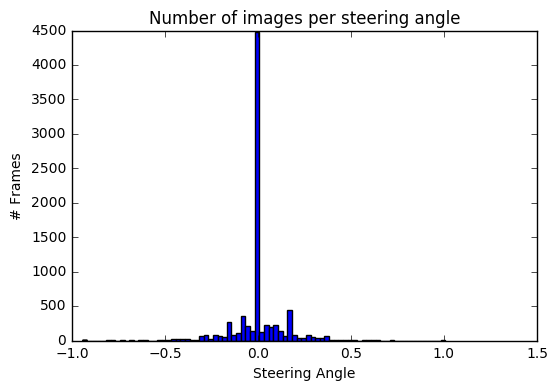

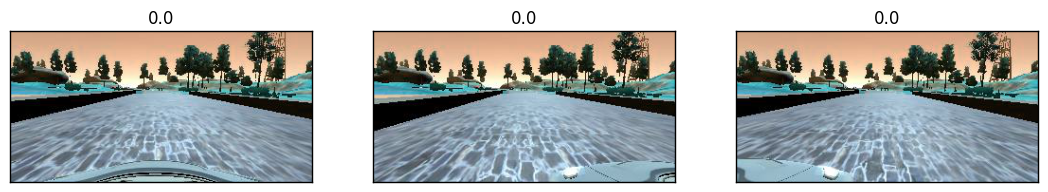

160 320 3


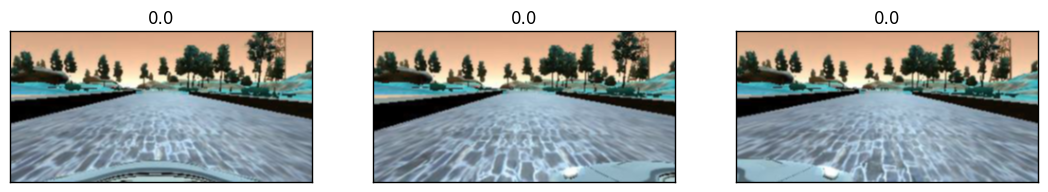

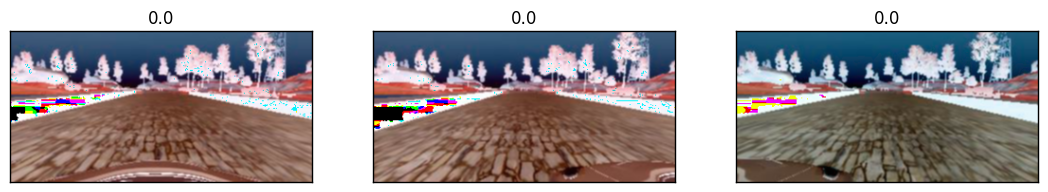

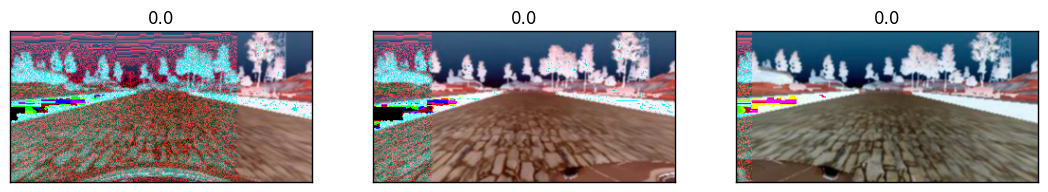

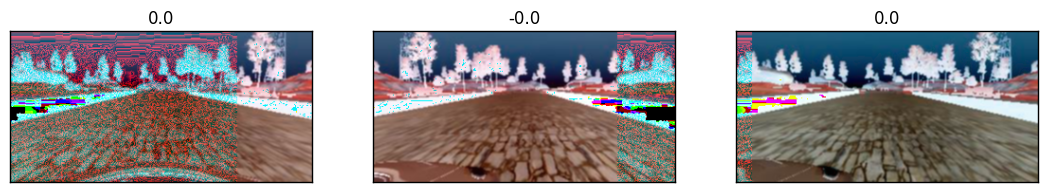

In [8]:
plot_steering_angles(data.steering_angle)

test_images, test_angles = [], []
with open('driving_log.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        steering_center = float(row[3])

        # create adjusted steering measurements for the side camera images
        correction = 0.25 # this is a parameter to tune
        steering_left = steering_center + correction
        steering_right = steering_center - correction

        # read in images from center, left and right cameras
        img_center = np.asarray(cv2.imread('./IMG/' + row[0].split('/')[-1]))
        img_left = np.asarray(cv2.imread('./IMG/' + row[1].split('/')[-1]))
        img_right = np.asarray(cv2.imread('./IMG/' + row[2].split('/')[-1]))
        test_angles.append(steering_center)
        test_angles.append(steering_center)
        test_angles.append(steering_center)
        break
#The original Image       
test_images.append(img_center)
test_images.append(img_left)
test_images.append(img_right)
h = img_center.shape[0]
w = img_center.shape[1]
plot_gallery_color(test_images, test_angles, h, w, 3)

#Preprocessed Image after cropping and blurring
img_center = image_preprocess(img_center)
img_left = image_preprocess(img_left)
img_right = image_preprocess(img_right)

test_images = []
test_images.append(img_center)
test_images.append(img_left)
test_images.append(img_right)

h = img_center.shape[0]
w = img_center.shape[1]
print (h, w, len(test_images))
plot_gallery_color(test_images, test_angles, h, w, 3)


#Preprocessed Image after Brightness 
image0 = brightness_shift(test_images[0]) 
image1 = brightness_shift(test_images[1])
image2 = brightness_shift(test_images[2])
test_images = []
test_images.append(image0)
test_images.append(image1)
test_images.append(image2)
plot_gallery_color(test_images, test_angles, h, w, 3)

#Preprocessed Image after Random Shadow 
image0 = random_shadow(test_images[0]) 
image1 = random_shadow(test_images[1])
image2 = random_shadow(test_images[2])
test_images = []
test_images.append(image0)
test_images.append(image1)
test_images.append(image2)
plot_gallery_color(test_images, test_angles, h, w, 3)

#Preprocessed Image after Horizontal Flip
image0, angle0 = horizontal_flip(test_images[0], test_angles[0])
image1, angle1 = horizontal_flip(test_images[1], test_angles[1])
image2, angle2 = horizontal_flip(test_images[2], test_angles[2])
test_images = []
test_angles = []
test_images.append(image0)
test_images.append(image1)
test_images.append(image2)
test_angles.append(angle0)
test_angles.append(angle1)
test_angles.append(angle2)
plot_gallery_color(test_images, test_angles, h, w, 3)




## Step 3: Generation of Batch Data 


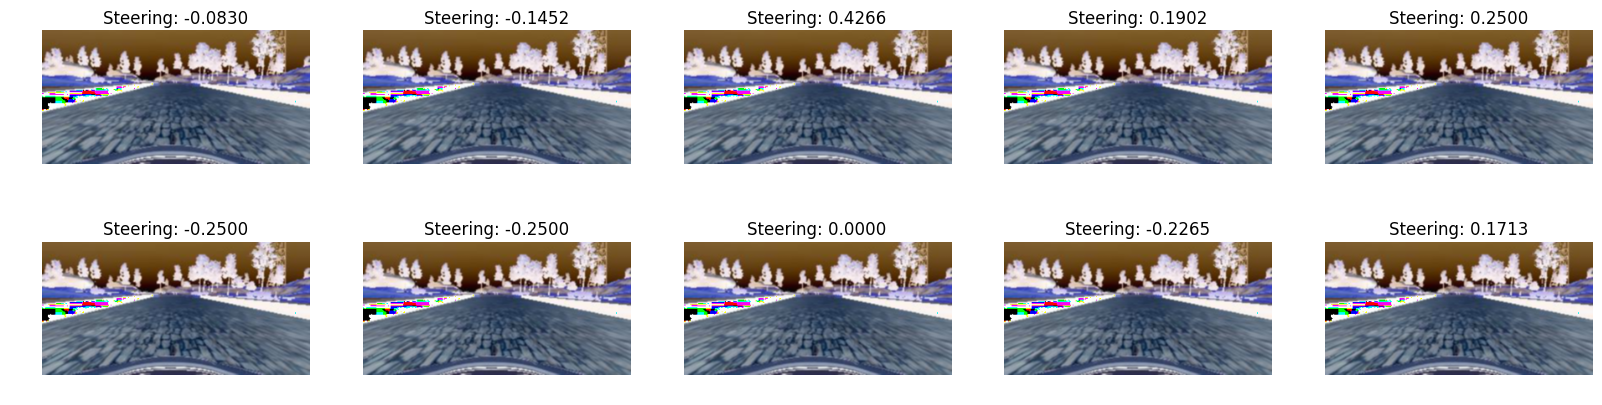

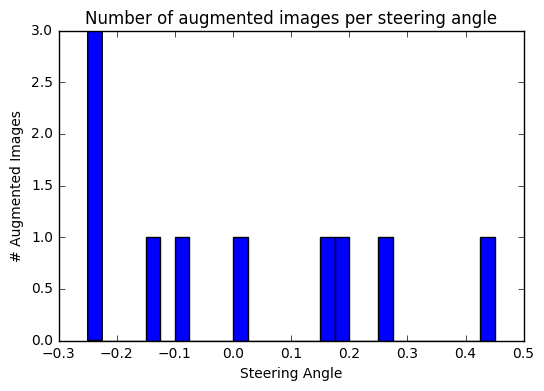

In [10]:
generated_steering_angles = []
generated_images = []
threshold = 0.75

def generate_batch_data(_data, batch_size = 32):
    
    batch_images = np.zeros((batch_size, PROCESSED_IMG_ROWS, PROCESSED_IMG_COLS, PROCESSED_IMG_CHANNELS))
    batch_steering = np.zeros(batch_size)

    
    while 1:
        for batch_index in range(batch_size):
            row_index = np.random.randint(len(_data))
            line_data = _data.iloc[[row_index]].reset_index()
           
            # idea borrowed from Vivek Yadav: Sample images such that images with lower angles 
            # have lower probability of getting represented in the dataset. This alleviates 
            # any problems we may ecounter due to model having a bias towards driving straight.           
            x, y = load_images_and_augment(line_data)
  
            batch_images[batch_index] = np.array(x)
            batch_steering[batch_index] = np.array(y)
            
            generated_images.append(x)
            generated_steering_angles.append(y)
            
        yield batch_images, batch_steering

iterator = generate_batch_data(X_train, batch_size=10)
sample_images, sample_steerings = iterator.__next__()

sample_images = np.array(sample_images)
sample_steerings = np.array(sample_steerings)

plt.subplots(figsize=(20, 5))
for i, img in enumerate(sample_images):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.title("Steering: {:.4f}".format(sample_steerings[i]))
    plt.imshow(img)
plt.show()

plt.hist(generated_steering_angles, bins=np.arange(min(generated_steering_angles), max(generated_steering_angles) + 0.025, 0.025))
plt.title('Number of augmented images per steering angle')
plt.xlabel('Steering Angle')
plt.ylabel('# Augmented Images')
plt.show()


## Step 4: Model Architecture - Nvidia and Commai Model

In [11]:
class LifecycleCallback(keras.callbacks.Callback):

    def on_epoch_begin(self, epoch, logs={}):
        pass

    def on_epoch_end(self, epoch, logs={}):
        global threshold
        threshold = 1 / (epoch + 1)

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_train_begin(self, logs={}):
        print('BEGIN TRAINING')
        self.losses = []

    def on_train_end(self, logs={}):
        print('END TRAINING')
        
# Calculate the correct number of samples per epoch based on batch size
def calc_samples_per_epoch(array_size, batch_size):
    num_batches = array_size / batch_size
    samples_per_epoch = math.ceil(num_batches)
    samples_per_epoch = samples_per_epoch * batch_size
    return samples_per_epoch

In [12]:
def commai():
    """
    Creates comm.ai Autonomous Car Group model
    """
    model = Sequential()
    model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(64, 64, 3), output_shape=(64, 64, 3)))
    model.add(Conv2D(16, (8, 8), padding="same", activation="elu", strides=(4, 4), name="Conv1"))
    model.add(Conv2D(32, (5, 5), padding="same", activation="elu", strides=(2, 2), name="Conv2"))
    model.add(Conv2D(64, (5, 5), padding="same", activation="elu", strides=(2, 2), name="Conv3"))
    model.add(Flatten(input_shape=(160,320,3)))
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512, activation='elu', name='FC1'))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1, name='output'))
    model.summary()
    return model


def nVidiaModel():
    """
    Creates nVidea Autonomous Car Group model
    """
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(PROCESSED_IMG_ROWS,PROCESSED_IMG_COLS,3)))
    model.add(Cropping2D(cropping=((50,20), (0,0))))   
    model.add(Conv2D(24, (5, 5), activation="elu", strides=(2, 2), name="Conv1"))
    model.add(Conv2D(36, (5, 5), activation="elu", strides=(2, 2), name="Conv2"))
    model.add(Conv2D(48, (5, 5), activation="elu", strides=(2, 2), name="Conv3"))
    model.add(Conv2D(64, (3, 3), activation="elu", name="Conv4"))
    model.add(Conv2D(64, (3, 3), activation="elu", name="Conv5"))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    return model

In [13]:
#Fit Generator Model

lifecycle_callback = LifecycleCallback()

# Reading images locations.
centerPaths, leftPaths, rightPaths, measurements = findImages('.')
imagePaths, measurements = combineImages(centerPaths, leftPaths, rightPaths, measurements, 0.2)
print('Total Images: {}'.format( len(imagePaths)))

# Splitting samples and creating generators.
from sklearn.model_selection import train_test_split
samples = list(zip(imagePaths, measurements))
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

print('Train samples: {}'.format(len(train_samples)))
print('Validation samples: {}'.format(len(validation_samples)))

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)


model = nVidiaModel()  

model.compile(optimizer='adam', loss='mse', metrics=[])

history_object = model.fit_generator(train_generator,
                              steps_per_epoch = len(train_samples),
                              epochs = EPOCH, verbose=1,
                              callbacks=[lifecycle_callback],
                              validation_data = validation_generator,
                              validation_steps = len(validation_samples))

model.save('model.h5')
print("Model saved")
print(history_object.history.keys())
print('Loss')
print(history_object.history['loss'])
print('Validation Loss')
print(history_object.history['val_loss'])


Total Images: 24108
Train samples: 19286
Validation samples: 4822
BEGIN TRAINING
Epoch 1/3
19286/19286 [==============================] - 6989s 362ms/step - loss: 0.0122 - val_loss: 0.0127
Epoch 2/3
19286/19286 [==============================] - 6945s 360ms/step - loss: 0.0017 - val_loss: 0.0112
Epoch 3/3
19286/19286 [==============================] - 6927s 359ms/step - loss: 8.2271e-04 - val_loss: 0.0109
END TRAINING
Model saved
dict_keys(['val_loss', 'loss'])
Loss
[0.012205415946233367, 0.0017183483779984183, 0.00082271581763713694]
Validation Loss
[0.01267307829929596, 0.011235005964807808, 0.010897670956192065]


NameError: name 'loadModel' is not defined

### Model Summary

In [17]:
load_model('model.h5').summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 43, 158, 24)       1824      
_________________________________________________________________
Conv2 (Conv2D)               (None, 20, 77, 36)        21636     
_________________________________________________________________
Conv3 (Conv2D)               (None, 8, 37, 48)         43248     
_________________________________________________________________
Conv4 (Conv2D)               (None, 6, 35, 64)         27712     
_________________________________________________________________
Conv5 (Conv2D)               (None, 4, 33, 64)         36928     
__________

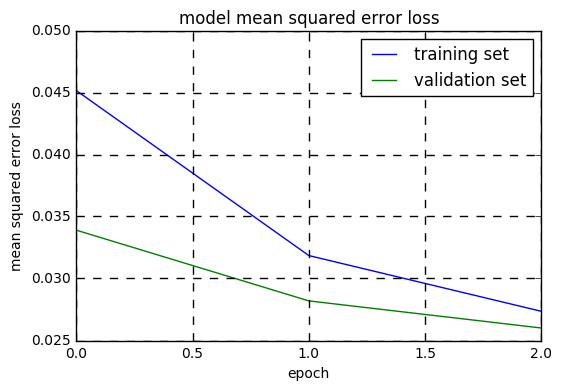

In [28]:
# dict_keys(['loss', 'val_loss'])
loss = [0.045153103061875123, 0.031848681302726264, 0.027354457760211899]
valid_loss = [0.033896364609334075, 0.028193514087644336, 0.026007735237962643]

### plot the training and validation loss for each epoch
plt.plot(loss)
plt.plot(valid_loss)
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.grid(color='black', linestyle='--', linewidth=1)
plt.show()

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='model.png')

img = read_image('model.png')
# original image
plt.subplots(figsize=(5,10))
plt.subplot(111)
plt.axis('off')
plt.imshow(array_to_img(img))